<a href="https://colab.research.google.com/github/harsha-9977/AIML/blob/main/monkey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ensure GPU is enabled: Runtime → Change runtime type → GPU
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
!pip install -q kaggle
from google.colab import files
files.upload()  # Upload your kaggle.json

# Kaggle setup
!mkdir -p ~/.kaggle && cp kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d slothkong/10-monkey-species
!unzip -q 10-monkey-species.zip -d /content/monkey_data && rm 10-monkey-species.zip



Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/slothkong/10-monkey-species
License(s): CC0-1.0
 95% 518M/547M [00:07<00:00, 83.4MB/s]
100% 547M/547M [00:07<00:00, 77.9MB/s]
Found 879 images belonging to 1 classes.
Found 219 images belonging to 1 classes.


In [3]:
# Install TensorFlow (already comes pre-installed in Colab)
!pip install -q tensorflow

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os


In [5]:
image_size = 224
batch_size = 32

train_dir = 'monkey_data/training'
val_dir = 'monkey_data/validation'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

num_classes = train_generator.num_classes


Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [6]:
base_model = MobileNetV2(weights='imagenet', include_top=False,
                         input_shape=(image_size, image_size, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.4338 - loss: 1.8038 - val_accuracy: 0.9375 - val_loss: 0.2177
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 858ms/step - accuracy: 0.8965 - loss: 0.3499 - val_accuracy: 0.9559 - val_loss: 0.1679
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 46s 998ms/step - accuracy: 0.9455 - loss: 0.1886 - val_accuracy: 0.9743 - val_loss: 0.1275
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 839ms/step - accuracy: 0.9363 - loss: 0.1812 - val_accuracy: 0.9669 - val_loss: 0.1161
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 848ms/step - accuracy: 0.9427 - loss: 0.1561 - val_accuracy: 0.9743 - val_loss: 0.1161
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 838ms/step - accuracy: 0.9733 - loss: 0.1048 - val_accuracy: 0.9632 - val_loss: 0.1074
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9672 - loss: 0.1020 - val_accuracy: 0.9816 - val_loss: 0.0821
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 35s 844ms/step - accuracy: 0.9707 - loss: 0.0914 - val_accuracy: 

In [8]:
model.save("monkey_model.h5")
print("✅ Model saved as monkey_model.h5")


✅ Model saved as monkey_model.h5


In [9]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc:.4f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 450ms/step - accuracy: 0.9895 - loss: 0.0572
Validation Accuracy: 0.9853


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class ID: n0
Predicted Species: mantled_howler


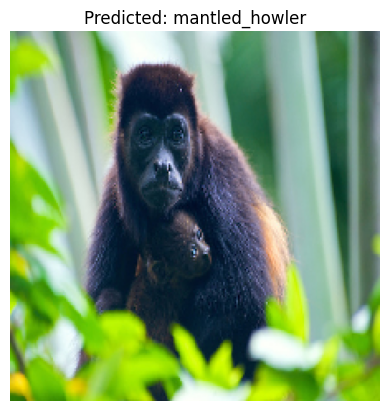

In [26]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

# Load and preprocess image
img_path = val_generator.filepaths[0]
img = image.load_img(img_path, target_size=(image_size, image_size))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
from tensorflow.keras.models import load_model
model = load_model('monkey_model.h5')

pred = model.predict(img_array)
predicted_class = np.argmax(pred[0])

# Get class label dictionary
class_labels = {v: k for k, v in train_generator.class_indices.items()}
predicted_class_id = class_labels[predicted_class]

# Load species map from file
species_map = {}
label_file_path = os.path.join('monkey_data', 'monkey_labels.txt')
with open(label_file_path, 'r') as f:
    next(f)  # skip header
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) == 3:
            class_id, latin_name, common_name = parts
            species_map[class_id] = common_name

# Get species name
predicted_species = species_map.get(predicted_class_id, "Unknown Species")

# Display result
print(f"Predicted Class ID: {predicted_class_id}")
print(f"Predicted Species: {predicted_species}")
plt.imshow(img)
plt.title(f"Predicted: {predicted_species}")
plt.axis('off')
plt.show()


In [27]:
print(train_generator.class_indices)  # e.g., {'n0': 0, 'n1': 1, ..., 'n9': 9}


{'n0': 0, 'n1': 1, 'n2': 2, 'n3': 3, 'n4': 4, 'n5': 5, 'n6': 6, 'n7': 7, 'n8': 8, 'n9': 9}


In [28]:
!pip install streamlit pyngrok --quiet


In [29]:
%%writefile app.py
import streamlit as st
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import load_model

# --- Load Model ---
@st.cache_resource
def load_trained_model():
    model = load_model('monkey_model.h5')  # Your trained model
    return model

# --- Load Labels ---
def load_label_map(label_file):
    label_dict = {}
    with open(label_file, 'r') as f:
        next(f)
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) == 3:
                class_id, latin, common = parts
                label_dict[class_id] = common
    return label_dict

# --- Preprocess Image ---
def preprocess_image(img, target_size=224):
    img = img.resize((target_size, target_size))
    img_array = keras_image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

st.title("🧠 Monkey Species Classifier")

uploaded_file = st.file_uploader("📷 Upload a monkey image", type=["jpg", "jpeg", "png"])

if uploaded_file:
    st.image(uploaded_file, caption='Uploaded Image', use_column_width=True)

    model = load_trained_model()
    species_map = load_label_map('monkey_dataset/monkey_labels.txt')
    class_indices = {
        'n0': 0, 'n1': 1, 'n2': 2, 'n3': 3, 'n4': 4,
        'n5': 5, 'n6': 6, 'n7': 7, 'n8': 8, 'n9': 9
    }
    class_labels = {v: k for k, v in class_indices.items()}

    img = Image.open(uploaded_file)
    img_array = preprocess_image(img)

    pred = model.predict(img_array)
    pred_class_index = np.argmax(pred[0])
    pred_class_id = class_labels.get(pred_class_index, "unknown")
    pred_species = species_map.get(pred_class_id, "Unknown Species")

    st.success(f"✅ Predicted Species: **{pred_species}**")


Overwriting app.py


In [2]:
!ngrok config add-authtoken 2zGQ8JjiFanrPui3ZAAfrPsEa4B_6fSgyfoSXiYTNoh5n41yQ


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [12]:
!wget -q -O ngrok.zip https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.zip
!unzip -o ngrok.zip
!chmod +x ngrok
!mv ngrok /usr/local/bin/ngrok
!ngrok version  # ✅ This should show 3.x.x


Archive:  ngrok.zip
  inflating: ngrok                   
ngrok version 3.23.3


In [3]:
!ngrok config add-authtoken 2zGQ8JjiFanrPui3ZAAfrPsEa4B_6fSgyfoSXiYTNoh5n41yQ


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [4]:
import subprocess
import time
import requests

# Start ngrok tunnel
subprocess.Popen(["ngrok", "http", "8501"])

# Wait for ngrok to initialize
time.sleep(4)

# Get public URL
try:
    url = requests.get("http://localhost:4040/api/tunnels").json()['tunnels'][0]['public_url']
    print("🌐 Public URL:", url)
except:
    print("❌ Failed to get public URL.")


🌐 Public URL: https://f29d-34-142-231-174.ngrok-free.app


In [6]:
import subprocess
import time
import requests

# Start ngrok tunnel
subprocess.Popen(["ngrok", "http", "8501"])
time.sleep(4)  # wait for ngrok to start

# Get the public URL
try:
    url = requests.get("http://localhost:4040/api/tunnels").json()['tunnels'][0]['public_url']
    print("🌐 Public URL:", url)
except Exception as e:
    print("❌ Could not get ngrok URL:", e)


🌐 Public URL: https://f29d-34-142-231-174.ngrok-free.app


In [15]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


In [16]:
# Load dataset from seaborn
import seaborn as sns
df = sns.load_dataset("diamonds")

# Use only selected numerical features
features = ['carat', 'depth', 'table', 'x', 'y', 'z']
target = 'price'

X = df[features]
y = df[target]

# Handle possible zeros in x, y, z (sometimes indicates data error)
X = X[(X[['x', 'y', 'z']] != 0).all(axis=1)]
y = y.loc[X.index]


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [18]:
models = {
    'Linear': LinearRegression(),
    'Lasso': Lasso(alpha=0.1),
    'Ridge': Ridge(alpha=1.0)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    coef_df = pd.DataFrame({
        'Feature': features,
        'Coefficient': model.coef_
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    results[name] = {
        'RMSE': rmse,
        'Top Features': coef_df.head(3)
    }


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.389e+09, tolerance: 6.843e+07
  model = cd_fast.enet_coordinate_descent(


In [19]:
for name, result in results.items():
    print(f"\n🔍 {name} Regression")
    print(f"📉 RMSE: {result['RMSE']:.2f}")
    print("🏆 Top 3 Features:")
    print(result['Top Features'].to_string(index=False))



🔍 Linear Regression
📉 RMSE: 1460.40
🏆 Top 3 Features:
Feature  Coefficient
  carat 10813.054264
      x  -996.559297
      z  -680.627282

🔍 Lasso Regression
📉 RMSE: 1458.75
🏆 Top 3 Features:
Feature  Coefficient
  carat 10797.777421
      x -1014.410579
      z  -629.935537

🔍 Ridge Regression
📉 RMSE: 1460.27
🏆 Top 3 Features:
Feature  Coefficient
  carat 10784.957900
      x  -989.436872
      z  -672.007685


In [16]:
# ✅ 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ 2. Load Dataset
df = sns.load_dataset('diamonds')
df = df[['carat', 'depth', 'table', 'x', 'y', 'z', 'price']]  # select numeric features

# ✅ 3. Define Features and Target
X = df.drop('price', axis=1)
y = df['price']

# ✅ 4. Normalize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ 5. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ✅ 6. Train Models
models = {
    "Linear": LinearRegression(),
    "Lasso": Lasso(alpha=0.1),
    "Ridge": Ridge(alpha=1.0)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    results[name] = {
        'model': model,
        'RMSE': rmse
    }

# ✅ 7. Print RMSE
print("🔍 RMSE Comparison:")
for name in results:
    print(f"{name} RMSE: {results[name]['RMSE']:.2f}")


🔍 RMSE Comparison:
Linear RMSE: 1497.39
Lasso RMSE: 1497.41
Ridge RMSE: 1497.39


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

# Load the dataset (replace with your path or use seaborn's built-in)
import seaborn as sns
diamonds = sns.load_dataset('diamonds')

# 1. Convert categorical variables into dummy/one-hot encoding
df = pd.get_dummies(diamonds, columns=['color', 'clarity'], drop_first=True)

# 2. Define X (features) and y (target)
X = df.drop(['price', 'cut'], axis=1)  # We drop 'cut' for simplicity
y = df['price']

# 3. Split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train Linear Regression
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))

# 5. Train Lasso Regression
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

# 6. Train Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

# 7. Print RMSE results
print(f"Linear Regression RMSE: {rmse_lin:.2f}")
print(f"Lasso Regression RMSE: {rmse_lasso:.2f}")
print(f"Ridge Regression RMSE: {rmse_ridge:.2f}")


Linear Regression RMSE: 1140.54
Lasso Regression RMSE: 1140.65
Ridge Regression RMSE: 1140.49


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load dataset
import seaborn as sns
diamonds = sns.load_dataset('diamonds')

# One-hot encode categorical features
df = pd.get_dummies(diamonds, columns=['color', 'clarity'], drop_first=True)

# Drop 'cut' for simplicity
df = df.drop(columns=['cut'])

# Features and target
X = df.drop('price', axis=1)
y = df['price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features for SVM (only for SVM!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Support Vector Regression
svm_model = SVR(kernel='rbf', C=1000, gamma=0.1)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)
rmse_svm = np.sqrt(mean_squared_error(y_test, y_pred_svm))

# 2. Decision Tree Regressor
dt_model = DecisionTreeRegressor(max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))

# 3. Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# Print all RMSEs
print(f"SVR RMSE:            {rmse_svm:.2f}")
print(f"Decision Tree RMSE:  {rmse_dt:.2f}")
print(f"Random Forest RMSE:  {rmse_rf:.2f}")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Load dataset
import seaborn as sns
diamonds = sns.load_dataset('diamonds')

# Encode categorical variables (drop 'cut' for simplicity)
df = pd.get_dummies(diamonds.drop(columns=['cut']), columns=['color', 'clarity'], drop_first=True)

# Define features and target
X = df.drop('price', axis=1)
y = df['price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features for SVR
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Linear SVR
svr_linear = SVR(kernel='linear', C=1000)
svr_linear.fit(X_train_scaled, y_train)
y_pred_linear = svr_linear.predict(X_test_scaled)
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))

# 2. SVR with RBF (Radial Basis Function)
svr_rbf = SVR(kernel='rbf', C=1000, gamma=0.1)
svr_rbf.fit(X_train_scaled, y_train)
y_pred_rbf = svr_rbf.predict(X_test_scaled)
rmse_rbf = np.sqrt(mean_squared_error(y_test, y_pred_rbf))

# 3. SVR with Polynomial kernel
svr_poly = SVR(kernel='poly', degree=3, C=1000, coef0=1)
svr_poly.fit(X_train_scaled, y_train)
y_pred_poly = svr_poly.predict(X_test_scaled)
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))

# Print RMSE for all SVR types
print(f"Linear SVR RMSE:   {rmse_linear:.2f}")
print(f"RBF SVR RMSE:      {rmse_rbf:.2f}")
print(f"Polynomial SVR RMSE: {rmse_poly:.2f}")


In [13]:
pip install librosa matplotlib


Waveform shape: (117601,)
Duration (sec): 5.333378684807256
Spectrogram shape (freq × time): (1025, 230)


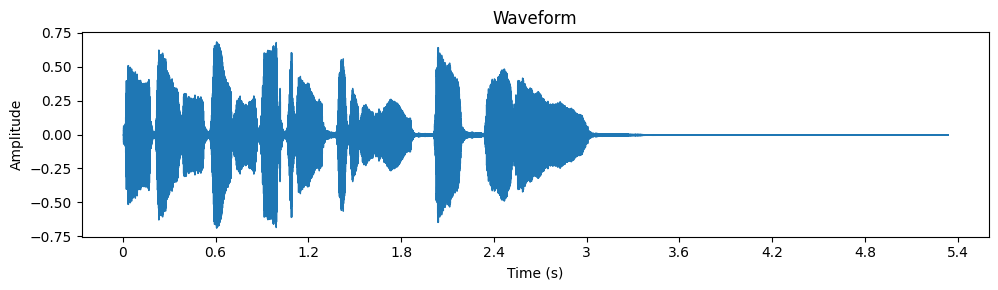

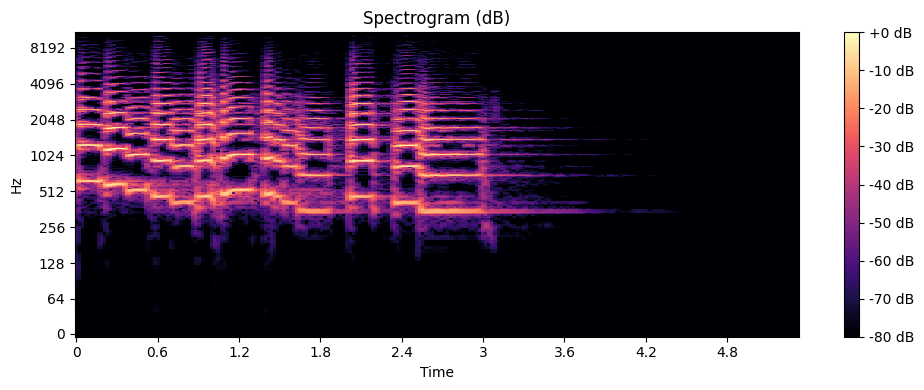

In [14]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# 📥 Load sample audio from librosa
audio_path = librosa.example('trumpet')  # ~5 sec trumpet audio
y, sr = librosa.load(audio_path)

# y: waveform (1D array of amplitude values)
# sr: sampling rate (e.g., 22050 Hz)

print("Waveform shape:", y.shape)
print("Duration (sec):", len(y)/sr)

# ✅ Convert to Spectrogram (Short-Time Fourier Transform)
S = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

print("Spectrogram shape (freq × time):", S_db.shape)

# ✅ Show waveform
plt.figure(figsize=(10, 3))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

# ✅ Show spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")
plt.tight_layout()
plt.show()


In [15]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Load sample audio (5s trumpet sound)
y, sr = librosa.load(librosa.example('trumpet'))

# Convert to Spectrogram
S = librosa.stft(y)  # Short-time Fourier transform → complex matrix
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)  # Convert to decibels

# Show matrix shape and values
print("🎵 Spectrogram Matrix Shape:", S_db.shape)
print("📊 Matrix Preview (first 5x5 values):\n", S_db[:5, :5])


🎵 Spectrogram Matrix Shape: (1025, 230)
📊 Matrix Preview (first 5x5 values):
 [[-80.      -80.      -80.      -80.      -80.     ]
 [-80.      -80.      -80.      -80.      -80.     ]
 [-80.      -80.      -80.      -80.      -80.     ]
 [-80.      -80.      -80.      -80.      -80.     ]
 [-79.21712 -80.      -80.      -80.      -80.     ]]


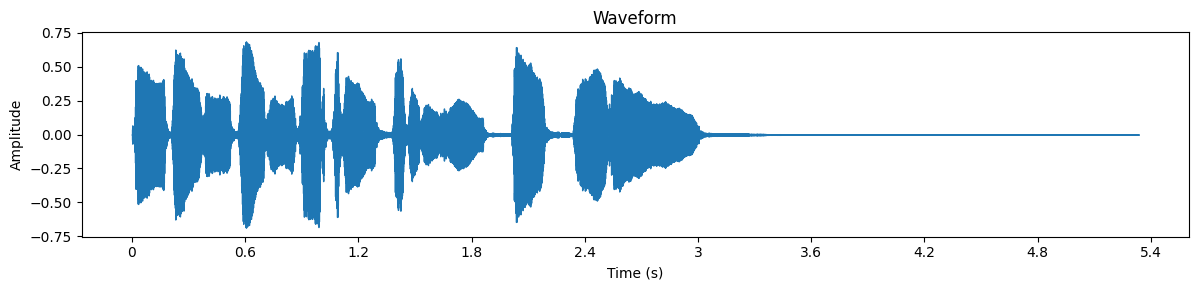

Waveform shape: (117601,)
Spectrogram shape: (1025, 230) (freq bins x time frames)
MFCC shape: (13, 230) (13 x time frames)


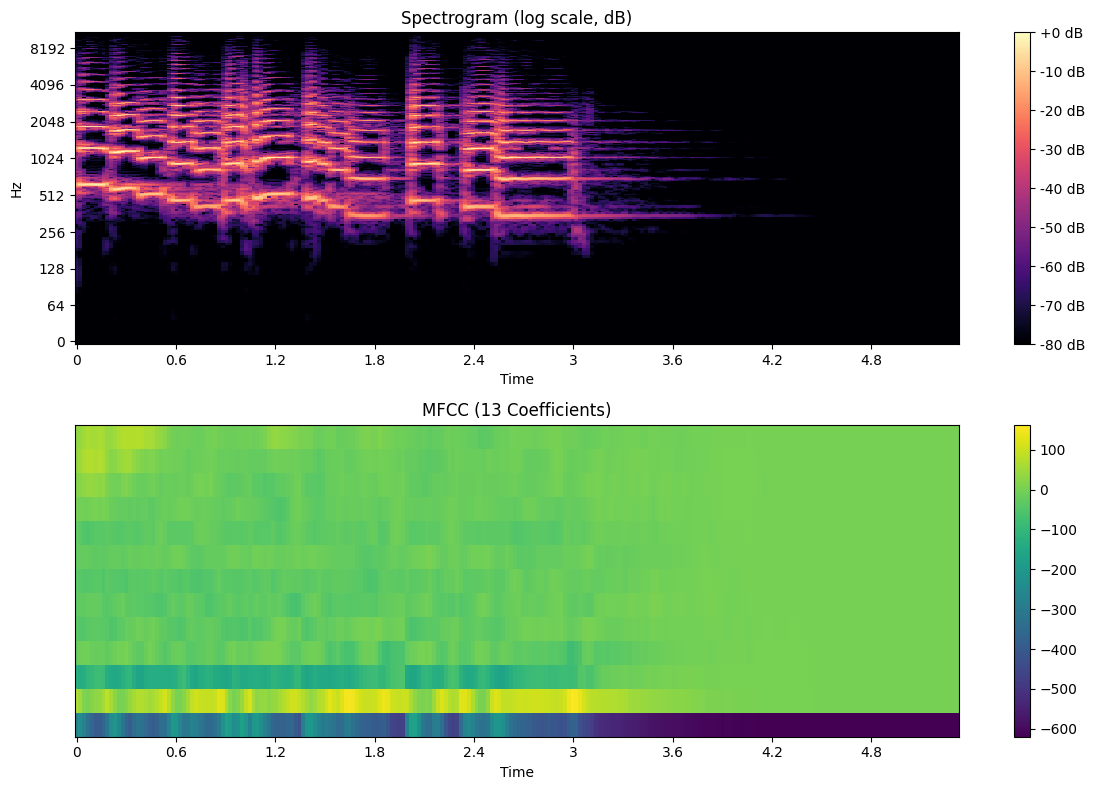

In [21]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# 📥 Load trumpet audio sample (~5 sec)
audio_path = librosa.example('trumpet')
y, sr = librosa.load(audio_path)

# Show waveform
plt.figure(figsize=(12, 3))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

# ✅ Compute Spectrogram
S = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

# ✅ Compute MFCC
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # 13 coefficients is typical

# 🔍 Print shapes
print(f"Waveform shape: {y.shape}")
print(f"Spectrogram shape: {S_db.shape} (freq bins x time frames)")
print(f"MFCC shape: {mfccs.shape} (13 x time frames)")

# 📊 Plot Spectrogram and MFCC
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# --- Spectrogram ---
img1 = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='magma', ax=ax[0])
ax[0].set_title("Spectrogram (log scale, dB)")
fig.colorbar(img1, ax=ax[0], format="%+2.0f dB")

# --- MFCC ---
img2 = librosa.display.specshow(mfccs, x_axis='time', sr=sr, cmap='viridis', ax=ax[1])
ax[1].set_title("MFCC (13 Coefficients)")
fig.colorbar(img2, ax=ax[1])

plt.tight_layout()
plt.show()


In [23]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Load audio
y, sr = librosa.load(librosa.example('trumpet'))

# Spectrogram
S = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

# MFCC
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# --- Set desired time (seconds) ---
desired_time_sec = 3.0  # You can change this to any time within the audio duration

# Convert time to frame index
hop_length = 512  # Default hop length in librosa.stft
frame_index = int(librosa.time_to_frames(desired_time_sec, sr=sr, hop_length=hop_length))

# Safety check
frame_index = min(frame_index, S_db.shape[1] - 1)

# --- Extract Column Vectors ---
spectrogram_column = S_db[:, frame_index]   # shape: (freq_bins,)
mfcc_column = mfccs[:, frame_index]         # shape: (13,)

# --- Print Results ---
print(f"🎯 Time: {desired_time_sec:.2f} sec → Frame index: {frame_index}")
print("\nSpectrogram Column (Amplitude in dB):")
print(spectrogram_column)

print("\nMFCC Coefficients:")
print(mfcc_column)


🎯 Time: 3.00 sec → Frame index: 129

Spectrogram Column (Amplitude in dB):
[-80. -80. -80. ... -80. -80. -80.]

MFCC Coefficients:
[-368.20868   162.1058    -85.89761   -80.21159   -22.60836   -32.272038
  -24.125973  -17.6987    -27.472975  -21.331535  -19.189379  -19.027878
  -11.387501]


In [ ]:
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt
import numpy as np

def audio_to_melspectrogram(file_path, save_path, size=(128, 128)):
    y, sr = librosa.load(file_path, duration=3, sr=22050)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_db = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(2, 2))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
    plt.axis('off')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 128
batch_size = 16

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    'spectrogram_data',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    'spectrogram_data',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_generator, validation_data=val_generator, epochs=10)


In [ ]:
def predict_audio(file_path):
    temp_img = "temp_spec.png"
    audio_to_melspectrogram(file_path, temp_img)

    from tensorflow.keras.preprocessing import image
    img = image.load_img(temp_img, target_size=(img_size, img_size))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)[0][0]
    if pred >= 0.5:
        print(f"🐶 Detected DOG sound! (Confidence: {pred:.2f})")
    else:
        print(f"❌ Not a dog sound (Confidence: {1 - pred:.2f})")
